# Post PYKX

In [194]:
import pykx as kx

## Carga de Datos

### Weather

In [195]:
weather = kx.q.read.csv('./dic_meteo22.csv', types='IIII****FSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFS', delimiter=';', as_table=True)

In [117]:
kx.q("5 #", weather).pd()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,108,81,b'28079108_81_98',b'2022',b'12',b'22',270.0,N,...,218.0,V,228.0,V,227.83,V,213.67,V,233.83,V
1,28,79,108,82,b'28079108_82_98',b'2022',b'12',b'22',9.0,N,...,10.0,V,10.0,V,9.00,V,9.00,V,8.00,V
2,28,79,108,83,b'28079108_83_98',b'2022',b'12',b'22',94.7,N,...,86.7,V,91.4,V,93.80,V,96.30,V,98.70,V
3,28,79,108,86,b'28079108_86_98',b'2022',b'12',b'22',1031.0,N,...,1031.0,V,1031.0,V,1031.00,V,1031.00,V,1031.00,V
4,28,79,108,87,b'28079108_87_98',b'2022',b'12',b'22',2.0,N,...,1.0,V,3.0,V,2.00,V,3.00,V,3.00,V


In [196]:
weather_station = kx.q.read.csv('./Estaciones_control_datos_meteorologicos.csv', types=" IFF", delimiter=";", as_table=True)

### Tráfico

In [197]:
traffic = kx.q.read.csv('./12-2022.csv', types = "IPSIIIISI", delimiter = ";", as_table = True)

In [120]:
kx.q("5#",traffic).pd()

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1001,2022-12-01 00:00:00,M30,3240,9,0,59,N,5
1,1001,2022-12-01 00:15:00,M30,3240,9,0,59,N,5
2,1001,2022-12-01 00:30:00,M30,300,1,0,66,N,5
3,1001,2022-12-01 00:45:00,M30,300,1,0,66,N,5
4,1001,2022-12-01 01:00:00,M30,300,1,0,66,N,5


In [198]:
traffic_station = kx.q.read.csv('./pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

## Cleaning Datasets

#### Weather

In [199]:
weather = kx.q.xcol({'ANO': 'year', 'MES': 'month', 'DIA': 'day', 'ESTACION':'weather_station', 'MAGNITUD':'magnitude'}, weather)
weather = kx.q.qsql.update(weather, columns = {'date': '"D"$(raze\')flip(year;month;day)'})
weather = kx.q.qsql.delete(weather, ['year', 'month', 'day', 'PUNTO_MUESTREO', 'PROVINCIA', 'MUNICIPIO'])

In [200]:
cols = kx.q.cols(weather)
def xexpr(pattern):
  xcols = cols[kx.q.where(kx.q.like(cols, pattern))]
  xsel = kx.q.sv(b";", kx.q.string(xcols)).py().decode("utf-8")
  return (xcols, 'flip(' + xsel + ')')

hour = 'count[i]#enlist 01:00*til 24'
(hcols, value) = xexpr(b'H*')
(vcols, valid) = xexpr(b'V*')

In [201]:
weather = kx.q.qsql.update(weather, columns = {'hour': hour, 'values': value, 'valid': valid})
weather = kx.q.qsql.update(weather, columns = {'date': 'date+hour'})
weather = kx.q.qsql.delete(weather, columns = kx.q.raze(hcols,vcols).py() + ["hour"])
weather = kx.q.ungroup(weather)
weather = kx.q('_', kx.q('1#`VALID'), kx.q.qsql.select(weather, where = 'valid=`V'))

In [202]:
magnitude = {80:"ultraviolet", 
             81:"wind", 
             82:"direction", 
             83:"temperature", 
             86:"humidity", 
             87:"pressure", 
             88:"solar", 
             89:"rainfall"}

weather = kx.q('{update magnitude: x magnitude from y}', magnitude, weather)
weather = kx.q('{exec (value x)#magnitude!values by date,weather_station from y}', magnitude, weather)

#### Traffic

In [209]:
traffic = kx.q.xasc("date", kx.q.qsql.select(traffic,
                         columns = {'traffic_load': 'avg carga'},
                         by = {"traffic_station": 'id', "date":'0D01:00:00 xbar fecha'}, 
                         where = "error=`N"))

**Location**

In [204]:
weather_station = kx.q.xcol({'CODIGO_CORTO' : 'weather_station', "LONGITUD":"longitude", "LATITUD":"latitude"}, weather_station)

In [205]:
traffic_station = kx.q.xcol({'id' : 'traffic_station', "longitud":"longitude", "latitud":"latitude"}, traffic_station)

In [ ]:
!pip install haversine

In [206]:
from haversine import haversine_vector, Unit
dist = kx.toq(
            haversine_vector(kx.q('`longitude`latitude#', weather_station).pd(), 
                             kx.q('`longitude`latitude#', traffic_station).pd(),
                             Unit.KILOMETERS, comb=True))

In [207]:
ids = kx.q.each(kx.q('{first where x=min x}'), dist)
distance_table = kx.q('^', traffic_station, weather_station[ids])
distance_table = kx.q.qsql.delete(distance_table, columns = ['tipo_elem','distrito','cod_cent','nombre','utm_x','utm_y','longitude', 'latitude'])

### Join Table

In [210]:
complete = kx.q.lj(traffic, kx.q.xkey('traffic_station', distance_table))
complete = kx.q.aj(kx.q('`weather_station`date'), complete, weather)
complete = kx.q.qsql.update(complete,  {"hour":"`hh$date", "weekday":'("d"$date)mod 7'})

In [211]:
kx.q("count", complete)

pykx.LongAtom(pykx.q('3170500'))

### Modelo

In [212]:
kx.q("minMaxScale:{[l] ({(x-y)%(z-y)}[;min l;max l]')l}")

final = kx.q.qsql.select(complete, columns = {"date": "date",
                                              "traffic_station":"traffic_station",
                                              "hour":"hour", 
                                              "weekday": "weekday", 
                                              "traffic_load": "minMaxScale traffic_load%100", 
                                              "temperature":"minMaxScale temperature", 
                                              "rainfall":"minMaxScale rainfall"},
                                    where = [
                                        "weekday>1",
                                        "9<hour",
                                        "hour<20",
                                        "40 <= (avg; traffic_load) fby traffic_station"
                                    ])


kx.q("""
    time_window:{[tt;data;lb]
        lb:lb+1;
        op:$[tt=`train;#;_];                                      / `train or `test decide the operator
        m:`rainfall`temperature`traffic_load`hour`weekday;        / the 5 columns we need
        data:?[data;();`traffic_station;m!({(y;(-;(count;x);80);x)}[;op]')m]; / first 80 or until the last 80 depending on operator 
        sw:{({y#z _x}[x;5;]')til count b:y _x}[;lb];              / sliding window function. takes turbomatrix and divides into chunks of 5x5
        gl:{y _(flip x)[2]}[;lb];                                  / gets the load (y data)
        toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x};    / table to matrix
        data:(toMatrix')data;                                     / convert each subtable (data is a keyed table) to a matrix
        X:(sw')data;                                              / apply sliding window to get X
        y:(gl')data;                                              / and gl to get y
        (X;y)                                                     / return both
        }
    """)
train = kx.q("time_window `train", final,5)
test = kx.q("time_window `test", final,5)

In [224]:
import numpy as np
np.array(test[0][3403].py())

array([[[ 0.        ,  0.07403545,  0.4275    , 10.        ,
          4.        ],
        [ 0.        ,  0.08446298,  0.475     , 11.        ,
          4.        ],
        [ 0.        ,  0.09384776,  0.435     , 12.        ,
          4.        ],
        [ 0.        ,  0.10740355,  0.54      , 13.        ,
          4.        ],
        [ 0.        ,  0.10427529,  0.51      , 14.        ,
          4.        ]],

       [[ 0.        ,  0.08446298,  0.475     , 11.        ,
          4.        ],
        [ 0.        ,  0.09384776,  0.435     , 12.        ,
          4.        ],
        [ 0.        ,  0.10740355,  0.54      , 13.        ,
          4.        ],
        [ 0.        ,  0.10427529,  0.51      , 14.        ,
          4.        ],
        [ 0.        ,  0.10531804,  0.4725    , 15.        ,
          4.        ]],

       [[ 0.        ,  0.09384776,  0.435     , 12.        ,
          4.        ],
        [ 0.        ,  0.10740355,  0.54      , 13.        ,
          4

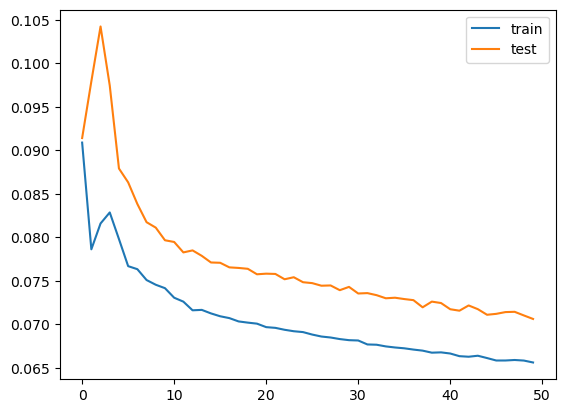

In [229]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Conv1D
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
# design network
model = Sequential()

#model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]))
model.add(LSTM(units = 50, return_sequences=True, input_shape=[None,5]))
model.add(Dense(units = 1))

model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(np.array(train[0][3403].py()), np.array(train[1][3403].py()), epochs=50, batch_size=8, validation_data=(np.array(test[0][3403].py()), np.array(test[1][3403].py())), verbose=0, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

In [152]:
pip install tensorflow

     ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
     --------------------------------------- 1.0/276.5 MB 22.0 MB/s eta 0:00:13
     --------------------------------------- 3.1/276.5 MB 32.7 MB/s eta 0:00:09
      -------------------------------------- 5.2/276.5 MB 37.1 MB/s eta 0:00:08
     - ------------------------------------- 8.4/276.5 MB 41.5 MB/s eta 0:00:07
     - ------------------------------------ 10.9/276.5 MB 50.1 MB/s eta 0:00:06
     - ------------------------------------ 13.6/276.5 MB 46.7 MB/s eta 0:00:06
     -- ----------------------------------- 16.3/276.5 MB 54.7 MB/s eta 0:00:05
     -- ----------------------------------- 18.9/276.5 MB 59.5 MB/s eta 0:00:05
     -- ----------------------------------- 21.5/276.5 MB 54.4 MB/s eta 0:00:05
     --- ---------------------------------- 24.8/276.5 MB 59.5 MB/s eta 0:00:05
     --- ---------------------------------- 26.5/276.5 MB 54.4 MB/s eta 0:00:05
     --- ---------------------------------- 27.

In [101]:
final = kx.q.qsql.select(complete, ["hour", "weekday", "date", "traffic_station", "load", "temperature", "rainfall"], 
                         where="weekday>1,9<hour,hour<20")
final = kx.q.qsql.select(complete, where="40 <= (avg; traffic_load) fby traffic_station")
final = kx.q.qsql.update(final,  {"load":"load%100"})

final

pykx.Table(pykx.q('
hour weekday date                          traffic_station load temperature rainfall
------------------------------------------------------------------------------------
0    5       2022.12.01D00:00:00.000000000 1001            0    6           0       
0    5       2022.12.01D00:00:00.000000000 1002            0    6           0       
0    5       2022.12.01D00:00:00.000000000 1003            0    6           0       
0    5       2022.12.01D00:00:00.000000000 1006            0    6           0       
0    5       2022.12.01D00:00:00.000000000 1009            0                        
0    5       2022.12.01D00:00:00.000000000 1010            0                        
0    5       2022.12.01D00:00:00.000000000 1011            0    7.1                 
0    5       2022.12.01D00:00:00.000000000 1012            0    7.1                 
0    5       2022.12.01D00:00:00.000000000 1013            0    7.1                 
0    5       2022.12.01D00:00:00.000000000 10

In [65]:
final

NameError: name 'final' is not defined

In [ ]:
### Análisis (No se si habría que meterlo)

In [ ]:
loads = kx.q.qsql.select(comp,
                         columns = {'carga_avg': 'avg carga'},
                         by = ['hour', 'weekday', 'estacion'])

temps = kx.q.qsql.select(comp,
                         columns = {'temps_avg': 'avg temperatura'},
                         by = ['hour'])

comp = kx.q("3!", comp)
comp = kx.q("1!0!", kx.q.lj(comp, loads))
comp = kx.q("0!", kx.q.lj(comp, temps))

comp = kx.q.qsql.update(comp,
                        columns = {'carga_v': 'carga-carga_avg',
                                   'temperatura_v': 'temperatura-temps_avg'})

#comp = kx.q('0^', comp)





In [22]:
comp

pykx.Table(pykx.q('
hour  weekday estacion direccion humedad precipitacion carga temperatura viento presion solar carga_avg temps_avg carga_v   temperatura_v
-----------------------------------------------------------------------------------------------------------------------------------------
00:00 0       24       286       52      0             0     14.1        2.34   954     1     9.404915  15.82441  -9.404915 -1.724408    
00:00 0       24       286       52      0             0     14.1        2.34   954     1     9.404915  15.82441  -9.404915 -1.724408    
00:00 0       24       286       52      0             0     14.1        2.34   954     1     9.404915  15.82441  -9.404915 -1.724408    
00:00 0       24       286       52      0             0     14.1        2.34   954     1     9.404915  15.82441  -9.404915 -1.724408    
01:00 0       24       314       55      0             0     12.8        1.36   954     1     6.894822  14.9231   -6.894822 -2.123101    
01:00 0       

In [23]:
final = kx.q.qsql.select(comp, columns = ["hour", "weekday", "fecha", "id", "carga", "temperatura", "precipitacion"])

QError: fecha

In [ ]:
final:  select hour, weekday, fecha, id, carga, temperatura, precipitacion from complete
final: `hour`weekday`date`traffic_station`traffic_load`temperature`rainfall xcol final

final:select from final where weekday>1,9<hour,hour<20
final:select from final where 40 <= (avg; traffic_load) fby traffic_station
final:update traffic_load:traffic_load%100 from final
        
comp

In [ ]:
# Filtrar:
    # 1. Weekday: No se si tenemos weekday. Sería quitar los sabados y domingos (no es muy importante si en q no es facil)
    # 2. Hora: Entre las 9 y las 20
    # 3. Fby por traffic station con Carga >= 40
final = complete[(complete["WEEKDAY"]<5) & (complete["HOUR"]>9) & (complete["HOUR"]<20)].reset_index()
final = final[final.groupby('traffic_station')['load'].transform('mean') >= 40]

# Modificar. Por ahora: 
final["load"]/=100
# Y si puede ser Escalado Min Max a rainfall y temperature: (X_i - min(X)) / (max(X)-min(X))
comp2[["rainfall", "temperature"]] = scaler.fit_transform(comp2.iloc[:, [5,7]])

# Tema indices. El resultado quiero que sea:
    # Estación de tráfico 0: [datos_t0, datos_t1, datos_t2, datos_t3, ...]
    # Estación de tráfico 1: [datos_t0, datos_t1, datos_t2, datos_t3, ...]
    # ...

final = final.set_index(['date'])

# De paso creo ya el train y test. Al final es lo mismo que antes pero por cada estación me quedo 
# los primeros datos para train y luego a partir del 80 para test
# 5: Rainfall, 7: Temperature, 12: Load, 13: Hour, 14: Weekday
train = final.groupby('traffic_station').apply(lambda x: np.array(x[:-80])[:,[5, 7, 12,13,14]].astype(float))
test  = final.groupby('traffic_station').apply(lambda x: np.array(x[-80:])[:,[5, 7, 12,13,14]].astype(float))

# Separar en Windows, Entrada: La estacion, el dataset y los pasos hacia atras.
# La salida: Matriz con shape: Las mediciones que se han hecho en el dataset - los pasos hacia atras, 
                            #  los pasos hacia atras,
                            #  los parametros.
def time_window(traffic_station, dataset, look_back=5):
    data_X,  data_y= [], []
    # Datos estacion
    station_data = dataset[traffic_station]
    
    # Por cada dato en la estacion
    for i in range(len(station_data)-look_back-1):
        # Guardamos en x una matriz con los datos de las últimas 5 rows (Esto es lo complicado)
        data_X.append(station_data[i:(i+look_back)])
        # Guardamos en y el último dato de load. Esto en verdad son los load que van desde look_back + 1 hasta el final.
        data_y.append(station_data[i+look_back+1, 2])

    return np.array(data_X), np.array(data_y)

# Utilizamos la funcion
train_X, train_y = time_window(3403, train)
test_X, test_y = time_window(3403, test)

In [8]:
wstation

pykx.KeyedTable(pykx.q('
ESTACION| CODIGO   LONGITUD 
--------| ------------------
4       | 28079004 -3.712257
8       | 28079008 -3.682316
16      | 28079016 -3.639242
18      | 28079018 -3.731836
24      | 28079024 -3.747345
35      | 28079035 -3.703166
36      | 28079036 -3.64531 
38      | 28079038 -3.70713 
39      | 28079039 -3.711536
54      | 28079054 -3.612139
56      | 28079056 -3.718768
58      | 28079058 -3.77461 
59      | 28079059 -3.616341
102     | 28079102 -3.635637
103     | 28079103 -3.709525
104     | 28079104 -3.679722
106     | 28079106 -3.74    
107     | 28079107 -3.656667
108     | 28079108 -3.717881
109     | 28079109 -3.69695 
110     | 28079110 -3.710792
111     | 28079111 -3.680369
112     | 28079112 -3.666456
113     | 28079113 -3.666456
114     | 28079114 -3.697631
115     | 28079115 -3.697631
'))

In [13]:
wstation

pykx.KeyedTable(pykx.q('
ESTACION| CODIGO   LONGITUD  LATITUD 
--------| ---------------------------
4       | 28079004 -3.712257 40.42388
8       | 28079008 -3.682316 40.42155
16      | 28079016 -3.639242 40.44005
18      | 28079018 -3.731836 40.39478
24      | 28079024 -3.747345 40.41936
35      | 28079035 -3.703166 40.41921
36      | 28079036 -3.64531  40.40795
38      | 28079038 -3.70713  40.44554
39      | 28079039 -3.711536 40.47823
54      | 28079054 -3.612139 40.37301
56      | 28079056 -3.718768 40.38503
58      | 28079058 -3.77461  40.51807
59      | 28079059 -3.616341 40.46073
102     | 28079102 -3.635637 40.39979
103     | 28079103 -3.709525 40.35063
104     | 28079104 -3.679722 40.36583
106     | 28079106 -3.74     40.44222
107     | 28079107 -3.656667 40.46278
108     | 28079108 -3.717881 40.47663
109     | 28079109 -3.69695  40.43191
110     | 28079110 -3.710792 40.4156 
111     | 28079111 -3.680369 40.42265
112     | 28079112 -3.666456 40.39647
113     | 28079113 -3.666

In [12]:
wjoin = kx.q.lj(weather, wstation)

QError: type